# ASRS Data Exploration & Multi-Label Encoding

Load 61 CSVs from `raw data/`, deduplicate by ACN, map anomaly strings to 13 top-level categories, and produce `data/asrs_multilabel.csv`.

In [1]:
import pandas as pd
import numpy as np
import glob, os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

RAW_DIR = "../raw data"
DATA_DIR = "../data"
RESULTS_DIR = "../results"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

## Step 1: Load & Concatenate All CSVs

In [2]:
files = sorted(glob.glob(os.path.join(RAW_DIR, "*.csv")))
print(f"Found {len(files)} CSV files")

dfs = [pd.read_csv(f, header=1, low_memory=False) for f in files]
df = pd.concat(dfs, ignore_index=True)
df.columns = df.columns.str.strip()
print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

Found 61 CSV files


Total rows: 282,371
Columns: 126


## Step 2: Deduplicate by ACN

In [3]:
print(f"Rows before dedup: {len(df):,}")
print(f"Unique ACNs: {df['ACN'].nunique():,}")

def merge_anomalies(series):
    """Combine anomaly strings from duplicate ACN rows, keeping unique values."""
    all_vals = []
    for val in series.dropna():
        for part in str(val).split(";"):
            part = part.strip()
            if part and part not in all_vals:
                all_vals.append(part)
    return "; ".join(all_vals) if all_vals else np.nan

def first_non_null(series):
    """Return the first non-null value in a series."""
    vals = series.dropna()
    return vals.iloc[0] if len(vals) > 0 else np.nan

dedup = df.groupby("ACN", sort=False).agg({
    "Anomaly": merge_anomalies,
    "Narrative": first_non_null,
    "Narrative.1": first_non_null,
    "Synopsis": first_non_null,
}).reset_index()

print(f"Rows after dedup: {len(dedup):,}")
print(f"Reports with Narrative.1: {dedup['Narrative.1'].notna().sum():,} ({dedup['Narrative.1'].notna().mean():.1%})")

Rows before dedup: 282,371
Unique ACNs: 172,183


Rows after dedup: 172,183
Reports with Narrative.1: 15,720 (9.1%)


## Step 3: Parse Anomalies & Raw Frequency Table

In [4]:
all_anomalies = []
for val in dedup["Anomaly"].dropna():
    for part in str(val).split(";"):
        part = part.strip()
        if part:
            all_anomalies.append(part)

counts = Counter(all_anomalies)
freq_df = pd.DataFrame(counts.most_common(), columns=["Anomaly", "Count"])
freq_df.to_csv(os.path.join(RESULTS_DIR, "anomaly_raw_frequencies.csv"), index=False)

print(f"Total anomaly mentions: {len(all_anomalies):,}")
print(f"Unique anomaly strings: {len(counts):,}")
print(f"\nTop 20 anomaly values:")
freq_df.head(20)

Total anomaly mentions: 507,624
Unique anomaly strings: 8,272

Top 20 anomaly values:


,Anomaly,Count
0,Deviation / Discrepancy - Procedural Published...,69608
1,Deviation / Discrepancy - Procedural Clearance,50836
2,Deviation / Discrepancy - Procedural FAR,32620
3,ATC Issue All Types,29422
4,Aircraft Equipment Problem Critical,28535
5,Other Unspecified,24817
6,Conflict Airborne Conflict,21269
7,Aircraft Equipment Problem Less Severe,20875
8,Deviation - Track / Heading All Types,20268
9,Inflight Event / Encounter Weather / Turbulence,17681


## Step 4: Map to 13 Top-Level Categories

In [5]:
CATEGORY_PREFIXES = [
    ("Aircraft Equipment Problem", "Aircraft Equipment Problem"),
    ("Airspace Violation", "Airspace Violation"),
    ("ATC Issue", "ATC Issue"),
    ("Conflict", "Conflict"),
    ("Deviation - Altitude", "Deviation - Altitude"),
    ("Deviation - Procedural", "Deviation / Discrepancy - Procedural"),
    ("Deviation - Speed", "Deviation - Speed"),
    ("Deviation - Track/Heading", "Deviation - Track"),
    ("Flight Deck/Cabin Event", "Flight Deck / Cabin"),
    ("Ground Event/Encounter", "Ground Event"),
    ("Ground Excursion", "Ground Excursion"),
    ("Ground Incursion", "Ground Incursion"),
    ("Inflight Event/Encounter", "Inflight Event"),
]

CATEGORY_NAMES = [name for name, _ in CATEGORY_PREFIXES]

def map_anomaly(raw_str):
    """Map a single raw anomaly string to a category name, or None."""
    for name, prefix in CATEGORY_PREFIXES:
        if raw_str.startswith(prefix):
            return name
    return None

# Count mapped vs unmapped unique values
mapped_unique = set()
unmapped_unique = set()
for val in counts:
    if map_anomaly(val) is not None:
        mapped_unique.add(val)
    else:
        unmapped_unique.add(val)

print(f"Mapped unique anomaly strings: {len(mapped_unique):,}")
print(f"Unmapped unique anomaly strings: {len(unmapped_unique):,}")

# Top 20 unmapped
unmapped_counts = [(v, counts[v]) for v in unmapped_unique]
unmapped_counts.sort(key=lambda x: -x[1])
print(f"\nTop 20 unmapped values:")
for val, cnt in unmapped_counts[:20]:
    print(f"  {cnt:>6,}  {val}")

Mapped unique anomaly strings: 64
Unmapped unique anomaly strings: 8,208

Top 20 unmapped values:
  24,817  Other Unspecified
   8,318  Critical
   4,932  Less Severe
   2,515  Other Airspace Violation Entry or Exit
   1,482  Other Runway Or Taxiway Excursion
     300  No Specific Anomaly Occurred Unwanted Situation
     140  Other ATC HANDLING
     114  Other SEE AND AVOID
     107  Other No Specific Anomaly Occurred
      87  Other FLC DISTR
      67  Other CLRNC INTERP
      65  Other Security Breach Concerns
      41  Other TCAS RA
      41  CRM
      37  Other CREW CONCEPT CRM
      36  Other SIMILAR CALL SIGNS
      34  Other FATIGUE
      33  Other ATC Handling
      32  Other CTLR HANDLING
      31  Other CREW CONCEPT


## Step 5: Build Multi-Label Matrix

In [6]:
def get_category_vector(anomaly_str):
    """Given a semicolon-delimited anomaly string, return a dict of binary flags for each category."""
    flags = {name: 0 for name in CATEGORY_NAMES}
    if pd.isna(anomaly_str):
        return flags
    for part in str(anomaly_str).split(";"):
        part = part.strip()
        if not part:
            continue
        cat = map_anomaly(part)
        if cat is not None:
            flags[cat] = 1
    return flags

label_records = dedup["Anomaly"].apply(get_category_vector).apply(pd.Series)
labeled = pd.concat([dedup[["ACN", "Narrative", "Narrative.1", "Synopsis", "Anomaly"]], label_records], axis=1)

# Count how many categories each report maps to
labeled["n_labels"] = label_records.sum(axis=1).astype(int)

print(f"Total reports: {len(labeled):,}")
print(f"Reports with >= 1 mapped category: {(labeled['n_labels'] > 0).sum():,}")
print(f"Reports with 0 mapped categories (unmapped only): {(labeled['n_labels'] == 0).sum():,}")

Total reports: 172,183
Reports with >= 1 mapped category: 172,183
Reports with 0 mapped categories (unmapped only): 0


## Step 6: Statistics & Visualizations

In [7]:
# Per-category counts
cat_counts = label_records.sum().sort_values(ascending=False).astype(int)
print("Per-category report counts:")
for cat, cnt in cat_counts.items():
    print(f"  {cnt:>7,}  {cat}")

# Label-count histogram
label_dist = labeled["n_labels"].value_counts().sort_index()
print(f"\nLabel count distribution:")
for n, cnt in label_dist.items():
    label = f"{n}" if n < 5 else "5+"
    print(f"  {label} labels: {cnt:,}")

# Imbalance ratio
max_cat = cat_counts.max()
min_cat = cat_counts.min()
print(f"\nImbalance ratio (max/min): {max_cat/min_cat:.1f}x")
print(f"  Most common:  {cat_counts.idxmax()} ({max_cat:,})")
print(f"  Least common: {cat_counts.idxmin()} ({min_cat:,})")

Per-category report counts:
  112,606  Deviation - Procedural
   49,305  Aircraft Equipment Problem
   46,285  Conflict
   38,658  Inflight Event/Encounter
   29,422  ATC Issue
   28,369  Deviation - Altitude
   20,268  Deviation - Track/Heading
   14,234  Ground Event/Encounter
   12,601  Ground Incursion
   12,291  Flight Deck/Cabin Event
    6,834  Airspace Violation
    5,000  Deviation - Speed
    3,718  Ground Excursion

Label count distribution:
  1 labels: 38,403
  2 labels: 77,602
  3 labels: 41,494
  4 labels: 12,224
  5+ labels: 2,178
  5+ labels: 260
  5+ labels: 21
  5+ labels: 1

Imbalance ratio (max/min): 30.3x
  Most common:  Deviation - Procedural (112,606)
  Least common: Ground Excursion (3,718)


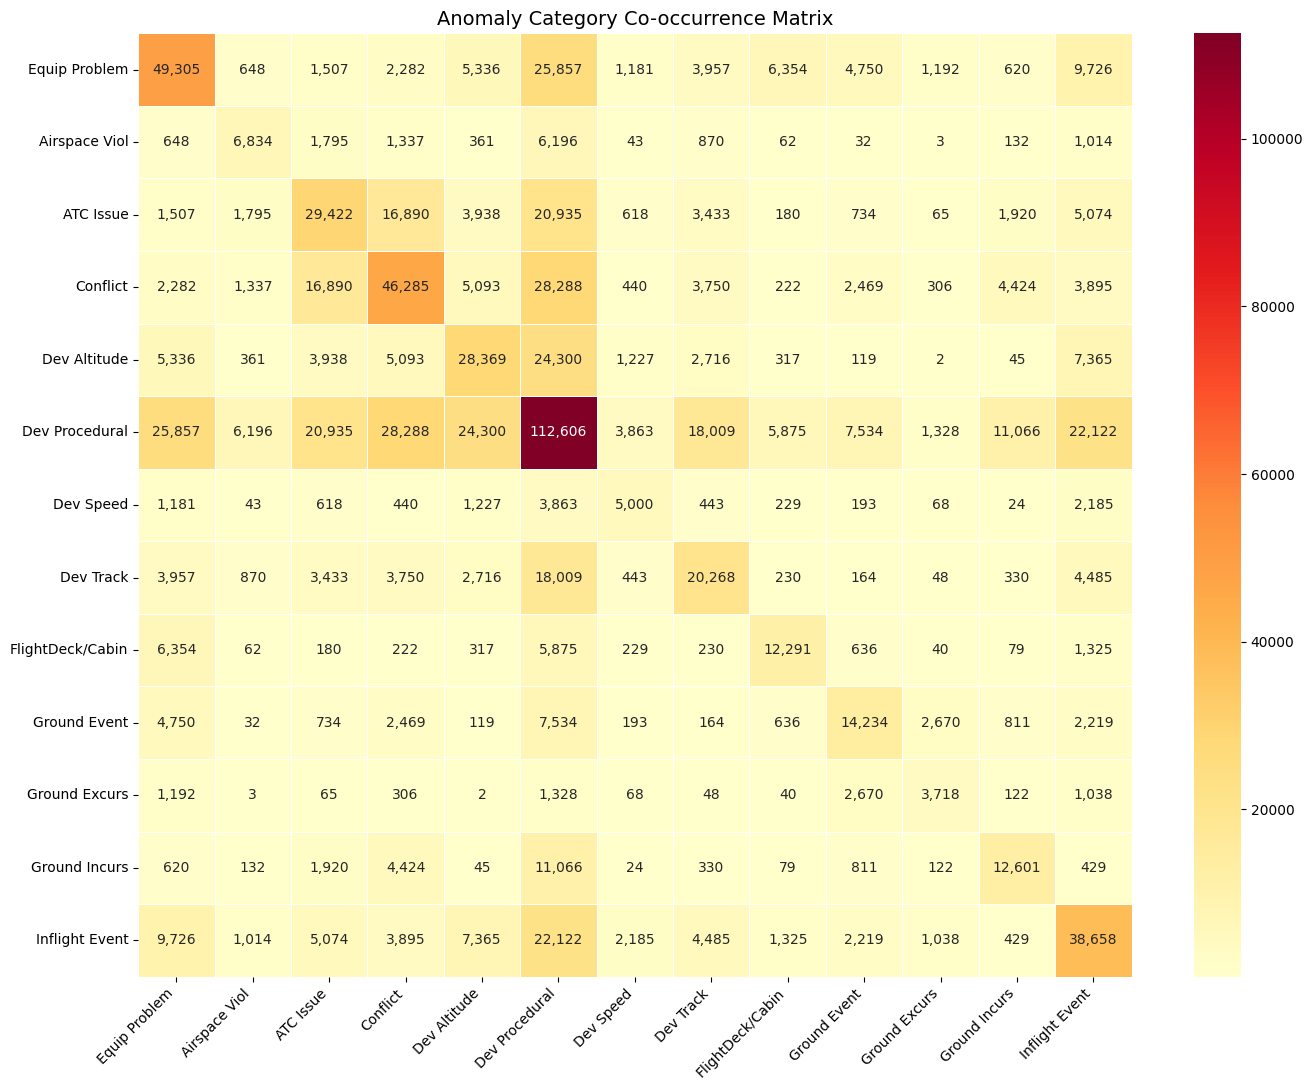

Saved co_occurrence_matrix.csv and co_occurrence_heatmap.png


In [8]:
# Co-occurrence matrix
label_matrix = label_records.values
co_occurrence = pd.DataFrame(
    label_matrix.T @ label_matrix,
    index=CATEGORY_NAMES,
    columns=CATEGORY_NAMES,
    dtype=int
)
co_occurrence.to_csv(os.path.join(RESULTS_DIR, "co_occurrence_matrix.csv"))

# Heatmap
fig, ax = plt.subplots(figsize=(14, 11))
# Use short labels for readability
short_names = [
    "Equip Problem", "Airspace Viol", "ATC Issue", "Conflict",
    "Dev Altitude", "Dev Procedural", "Dev Speed", "Dev Track",
    "FlightDeck/Cabin", "Ground Event", "Ground Excurs", "Ground Incurs",
    "Inflight Event"
]
sns.heatmap(
    co_occurrence,
    annot=True, fmt=",d", cmap="YlOrRd",
    xticklabels=short_names,
    yticklabels=short_names,
    linewidths=0.5,
    ax=ax
)
ax.set_title("Anomaly Category Co-occurrence Matrix", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "co_occurrence_heatmap.png"), dpi=150)
plt.show()
print("Saved co_occurrence_matrix.csv and co_occurrence_heatmap.png")

In [9]:
# Save summary stats to text file
mapped_reports = (labeled["n_labels"] > 0).sum()
unmapped_reports = (labeled["n_labels"] == 0).sum()

lines = [
    "ASRS Data Exploration Summary",
    "=" * 40,
    f"Raw CSV files: {len(files)}",
    f"Total rows (before dedup): {len(df):,}",
    f"Unique reports (after dedup by ACN): {len(dedup):,}",
    f"Reports with second narrative: {dedup['Narrative.1'].notna().sum():,} ({dedup['Narrative.1'].notna().mean():.1%})",
    "",
    f"Unique raw anomaly strings: {len(counts):,}",
    f"Mapped to categories: {len(mapped_unique):,} unique strings",
    f"Unmapped: {len(unmapped_unique):,} unique strings",
    "",
    f"Reports with >= 1 mapped category: {mapped_reports:,} ({mapped_reports/len(dedup):.1%})",
    f"Reports with 0 mapped categories: {unmapped_reports:,} ({unmapped_reports/len(dedup):.1%})",
    "",
    "Per-category counts (sorted):",
]
for cat, cnt in cat_counts.items():
    lines.append(f"  {cnt:>7,}  {cat}")

lines.append("")
lines.append("Label count distribution:")
for n, cnt in label_dist.items():
    lines.append(f"  {n} labels: {cnt:,}")

lines.append("")
lines.append(f"Imbalance ratio (max/min): {max_cat/min_cat:.1f}x")
lines.append(f"  Most common:  {cat_counts.idxmax()} ({max_cat:,})")
lines.append(f"  Least common: {cat_counts.idxmin()} ({min_cat:,})")

summary_text = "\n".join(lines)
with open(os.path.join(RESULTS_DIR, "data_exploration_summary.txt"), "w") as f:
    f.write(summary_text)

print(summary_text)
print(f"\nSaved to {RESULTS_DIR}/data_exploration_summary.txt")

ASRS Data Exploration Summary
Raw CSV files: 61
Total rows (before dedup): 282,371
Unique reports (after dedup by ACN): 172,183
Reports with second narrative: 15,720 (9.1%)

Unique raw anomaly strings: 8,272
Mapped to categories: 64 unique strings
Unmapped: 8,208 unique strings

Reports with >= 1 mapped category: 172,183 (100.0%)
Reports with 0 mapped categories: 0 (0.0%)

Per-category counts (sorted):
  112,606  Deviation - Procedural
   49,305  Aircraft Equipment Problem
   46,285  Conflict
   38,658  Inflight Event/Encounter
   29,422  ATC Issue
   28,369  Deviation - Altitude
   20,268  Deviation - Track/Heading
   14,234  Ground Event/Encounter
   12,601  Ground Incursion
   12,291  Flight Deck/Cabin Event
    6,834  Airspace Violation
    5,000  Deviation - Speed
    3,718  Ground Excursion

Label count distribution:
  1 labels: 38,403
  2 labels: 77,602
  3 labels: 41,494
  4 labels: 12,224
  5 labels: 2,178
  6 labels: 260
  7 labels: 21
  9 labels: 1

Imbalance ratio (max/min)

## Step 7: Save Processed Multi-Label Dataset

In [10]:
# Combine Narrative + Narrative.1
def combine_narratives(row):
    parts = []
    if pd.notna(row["Narrative"]):
        parts.append(str(row["Narrative"]).strip())
    if pd.notna(row["Narrative.1"]):
        parts.append(str(row["Narrative.1"]).strip())
    return " ".join(parts) if parts else np.nan

labeled["Narrative_combined"] = labeled.apply(combine_narratives, axis=1)

# Filter to only reports with at least one mapped category
output = labeled[labeled["n_labels"] > 0][["ACN", "Narrative_combined"] + CATEGORY_NAMES].copy()
output = output.rename(columns={"Narrative_combined": "Narrative"})

# Drop rows with no narrative text
output = output[output["Narrative"].notna()].reset_index(drop=True)

output.to_csv(os.path.join(DATA_DIR, "asrs_multilabel.csv"), index=False)
print(f"Saved {len(output):,} reports to {DATA_DIR}/asrs_multilabel.csv")
print(f"Columns: {list(output.columns)}")
print(f"\nSample:")
output.head(3)

Saved 172,183 reports to ../data/asrs_multilabel.csv
Columns: ['ACN', 'Narrative', 'Aircraft Equipment Problem', 'Airspace Violation', 'ATC Issue', 'Conflict', 'Deviation - Altitude', 'Deviation - Procedural', 'Deviation - Speed', 'Deviation - Track/Heading', 'Flight Deck/Cabin Event', 'Ground Event/Encounter', 'Ground Excursion', 'Ground Incursion', 'Inflight Event/Encounter']

Sample:


,ACN,Narrative,Aircraft Equipment Problem,Airspace Violation,ATC Issue,Conflict,Deviation - Altitude,Deviation - Procedural,Deviation - Speed,Deviation - Track/Heading,Flight Deck/Cabin Event,Ground Event/Encounter,Ground Excursion,Ground Incursion,Inflight Event/Encounter
0,2013675,This was filed under Aircraft X. At approximat...,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2013804,Awakened by First officer to HYD 3 leak. Slow ...,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2014030,Engine fire during start up attempt at ZZZ. Fo...,1,0,0,0,0,0,0,0,1,0,0,0,0
